In [2]:
pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Set random seed.
np.random.seed(42)

# Read the processed CSV file.
df = pd.read_csv("ms_data.csv")

# Convert visit_date to datetime.
df['visit_date'] = pd.to_datetime(df['visit_date'])

#  Sort by patient_id and visit_date.
df = df.sort_values(by = ['patient_id', 'visit_date'])

# Read insurance types from `insurance.lst`.
with open('insurance.lst', 'r') as f:
    insurance_types = [line.strip() for line in f.readlines()]

# Randomly assign (but keep consistent per patient_id).
unique_patients = df['patient_id'].unique()
patient_insurance_map = {patient_id: np.random.choice(insurance_types) for patient_id in unique_patients}
df['insurance_type'] = df['patient_id'].map(patient_insurance_map)

# Generate visit costs based on insurance type. Different plans have different effects on cost.
base_costs = {'Medicare': 100,
    'Medicaid': 200,
    'Private': 50,
    'Other': 500
}

# Add random variation.
variation_factor = 0.2 # 20% variation
df['visit_cost'] = df['insurance_type'].map(base_costs) * (1 + np.random.uniform(-variation_factor, variation_factor, len(df))).round(3)

# Set appropriate data types.
df['patient_id'] = df['patient_id'].astype(str)
df['education_level'] = df['education_level'].astype(str)
df['insurance_type'] = df['insurance_type'].astype(str)

# Spring: March, April, May (months 3, 4, 5)
# Summer: June, July, August (months 6, 7, 8)
# Fall: September, October, November (months 9, 10, 11)
# Winter: December, January, February (months 12, 1, 2)

# Add a 'season' column based on the month of the visit_date
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Apply the get_season function to the 'visit_date' to categorize the season
df['season'] = df['visit_date'].dt.month.apply(get_season)

df.head()

,patient_id,visit_date,age,education_level,walking_speed,insurance_type,visit_cost,season
0,P0001,2020-01-23,34.28,Bachelors,4.40,Private,53.95,Winter
1,P0001,2020-04-16,34.51,Bachelors,4.19,Private,50.70,Spring
2,P0001,2020-07-03,34.72,Bachelors,4.71,Private,46.20,Summer
3,P0001,2020-10-15,35.00,Bachelors,4.86,Private,56.30,Fall
4,P0001,2020-12-29,35.21,Bachelors,4.50,Private,53.70,Winter


In [25]:
df['visit_date'] = pd.to_datetime(df['visit_date'])
df['patient_id'] = df['patient_id'].astype(str)
df['education_level'] = df['education_level'].astype(str)
df['age'] = df['age'].astype(float)
df['walking_speed'] = df['walking_speed'].astype(float)
df['visit_cost'] = df['visit_cost'].astype(float)
df['season'] = df['season'].astype(str)
print(df.dtypes)

print(f"Number of missing values in each column: {df.isnull().sum()}")
print(f"Number of rows with at least one missing value: {df.isnull().any(axis=1).sum()}")

patient_id                 object
visit_date         datetime64[ns]
age                       float64
education_level            object
walking_speed             float64
insurance_type             object
visit_cost                float64
season                     object
dtype: object
Number of missing values in each column: patient_id         0
visit_date         0
age                0
education_level    0
walking_speed      0
insurance_type     0
visit_cost         0
season             0
dtype: int64
Number of rows with at least one missing value: 0


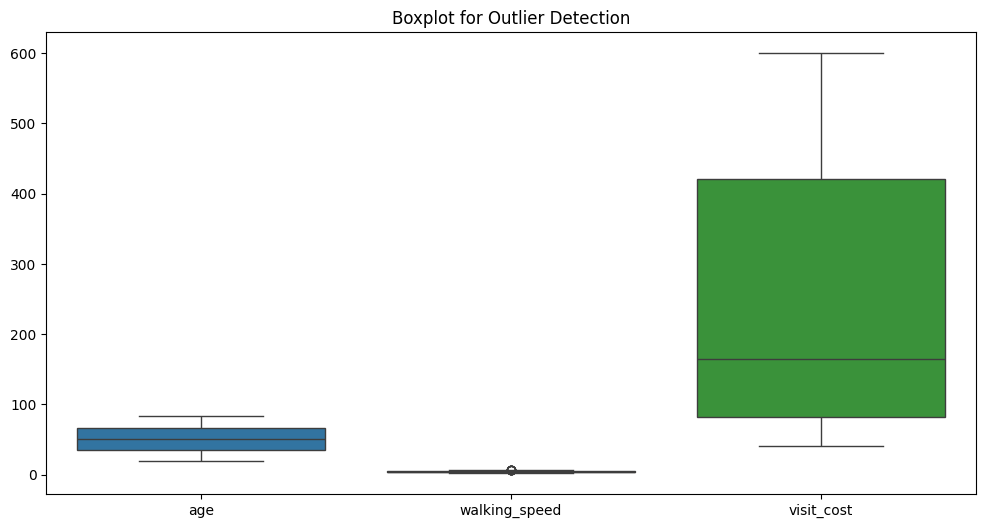

In [27]:
# Check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['age', 'walking_speed', 'visit_cost']])
plt.title('Boxplot for Outlier Detection')
plt.show()

# remove outliers based on Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

# Q3.1

In [28]:
# 1. Analyze walking speed:
#    - Multiple regression with education and age (report coeffcients and confidence intervals)
#    - Account for repeated measures
#    - Test for significant trends

# Prepare the data as before
X = df[['age']]
X = pd.get_dummies(df['education_level'], drop_first=True).join(X)  # Convert education_level to dummy variables
X = sm.add_constant(X)  # Add intercept

y = df['walking_speed']

# Ensure that X and y are purely numeric arrays
X = X.astype(float) 
y = y.astype(float)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Clustered standard errors by patient_id
clustered_se = model.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the summary with clustered standard errors
print(clustered_se.summary())

# Clustered Standard Errors: The cov_type='cluster' argument in get_robustcov_results accounts for the fact that there are repeated measurements for each subject. The groups=df['id'] argument specifies that the clustering should be done by the subject identifier (id).

# Interpretation: The coefficients remain the same, but now the standard errors are adjusted for the repeated measurements, which leads to more accurate statistical tests (e.g., p-values).

                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                 2.051e+04
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:21:58   Log-Likelihood:                -5399.8
No. Observations:               15429   AIC:                         1.081e+04
Df Residuals:                   15424   BIC:                         1.085e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.5986      0.008    690.039   

In [29]:
print(clustered_se.params) # Coefficients 
print(clustered_se.pvalues) # P-values
print(clustered_se.conf_int()) # Confidence Intervals
print(clustered_se.rsquared_adj)
print(clustered_se.rsquared)

[ 5.59859248  0.41457705 -0.79234258 -0.39034488 -0.03012607]
[0.000000e+000 0.000000e+000 0.000000e+000 3.337334e-318 0.000000e+000]
[[ 5.58267114  5.61451382]
 [ 0.40096613  0.42818797]
 [-0.80559317 -0.77909199]
 [-0.40370504 -0.37698473]
 [-0.03039607 -0.02985608]]
0.8069915853145198
0.807041626386515


In [8]:
# Test for trends.
# Manually added interaction terms between age and education_level.
# Creating new columns for each level of education.

# Convert 'education_level' into dummy variables
X_education = pd.get_dummies(df['education_level'], drop_first=True)

# Add 'age' as a predictor
X_education = X_education.join(df[['age']])

# Create interaction terms between 'age' and each education level
for level in X_education.columns[1:]:  # Skip the constant (first column)
    X_education[f'age_{level}'] = X_education['age'] * X_education[level]

# Add constant term
X_education = sm.add_constant(X_education)

# Ensure X and y are numeric
X_education = X_education.astype(float)

# Fit the OLS model
model_education = sm.OLS(y, X_education).fit()

clustered_se2 = model_education.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the model summary
print(clustered_se2.summary())

                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                 1.202e+04
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:56:42   Log-Likelihood:                -5411.6
No. Observations:               15431   AIC:                         1.084e+04
Df Residuals:                   15423   BIC:                         1.090e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.6021      0.024  

In [11]:
X_season = pd.get_dummies(df['season'], drop_first=True)

# Add 'age' as a predictor
X_season = X_season.join(df[['age']])

# Create interaction terms between 'age' and each season
for level in X_season.columns[1:]:  # Skip the constant (first column)
    X_season[f'age_{level}'] = X_season['age'] * X_season[level]

# Add constant term
X_season = sm.add_constant(X_season)

# Ensure X and y are numeric
X_season = X_season.astype(float)

# Fit the OLS model
model_season = sm.OLS(y, X_season).fit()

clustered_se3 = model_season.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the model summary
print(clustered_se3.summary())

                            OLS Regression Results                            
Dep. Variable:             visit_cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.080
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.374
Time:                        22:58:12   Log-Likelihood:            -1.0228e+05
No. Observations:               15431   AIC:                         2.046e+05
Df Residuals:                   15423   BIC:                         2.046e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        206.7482     47.544      4.349      0.0

# Q3.2

In [18]:
# 2. Analyze costs:
#    - Simple analysis of insurance type effect
#    - Box plots and basic statistics (report coeffcients and confidence intervals)
#    - Calculate effect sizes

# Convert insurance_type into dummy variables (one-hot encoding)
X = pd.get_dummies(df['insurance_type'], drop_first=True)

# Add 'visit_cost' as dependent variable
y = df['visit_cost']

# Add a constant to the model for intercept
X = sm.add_constant(X)

X = X.astype(float) 
y = y.astype(float)

# Fit the OLS model
model = sm.OLS(y, X).fit()

model_clustered = model.get_robustcov_results(cov_type='cluster', groups=df['patient_id'])

# Display the summary of the regression
print(model_clustered.summary())


                            OLS Regression Results                            
Dep. Variable:             visit_cost   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 1.509e+05
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:06:26   Log-Likelihood:                -75903.
No. Observations:               15431   AIC:                         1.518e+05
Df Residuals:                   15427   BIC:                         1.518e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        198.9878      0.401    496.275      0.0

In [ ]:
print(model_clustered.params) # Coefficients 
print(model_clustered.pvalues) # P-values
print(model_clustered.conf_int()) # Confidence Intervals
print(model_clustered.rsquared_adj)
print(model_clustered.rsquared)

[ 198.98776897  -99.06586493  300.03181628 -148.9185683 ]
[0. 0. 0. 0.]
[[ 198.20094348  199.77459446]
 [ -99.92875253  -98.20297732]
 [ 298.25681718  301.80681538]
 [-149.72806156 -148.10907504]]
0.96726176821306
0.9672681333909836


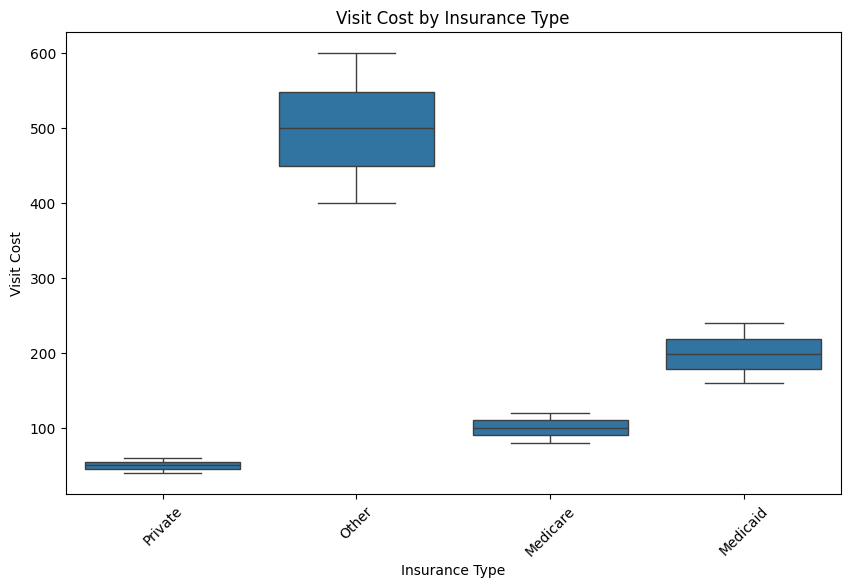

                 count        mean        std    min     25%     50%    75%  \
insurance_type                                                                
Medicaid        3532.0  198.987769  23.006670  160.0  178.95  198.10  219.0   
Medicare        3981.0   99.921904  11.590122   80.0   90.00   99.60  110.3   
Other           4340.0  499.019585  57.601562  400.0  449.50  499.50  548.5   
Private         3578.0   50.069201   5.775010   40.0   45.00   50.05   55.1   

                  max  
insurance_type         
Medicaid        240.0  
Medicare        120.0  
Other           600.0  
Private          60.0  


In [14]:
# Box plots to visualize the distribution of visit_cost by insurance type
plt.figure(figsize=(10, 6))
sns.boxplot(x='insurance_type', y='visit_cost', data=df)
plt.title('Visit Cost by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Visit Cost')
plt.xticks(rotation=45)
plt.show()

# Basic statistics for visit_cost by insurance type
statistics = df.groupby('insurance_type')['visit_cost'].describe()
print(statistics)

In [30]:
# Perform one-way ANOVA to check if visit_cost differs across insurance types
anova_result = stats.f_oneway(*(df[df['insurance_type'] == group]['visit_cost'] for group in df['insurance_type'].unique()))

# Calculate eta squared for effect size
n = len(df)
k = len(df['insurance_type'].unique())
ss_total = np.sum((df['visit_cost'] - np.mean(df['visit_cost']))**2)
ss_between = np.sum([(len(group) * (np.mean(group) - np.mean(df['visit_cost']))**2) for group in [df[df['insurance_type'] == group]['visit_cost'] for group in df['insurance_type'].unique()]])
eta_squared = ss_between / ss_total

print(f"Eta Squared: {eta_squared}")


Eta Squared: 0.9672688910650268


# Q3.3

In [21]:
# 3. Advanced analysis:
#    - Education age interaction effects on walking speed
#    - Control for relevant confounders
#    - Report key statistics and p-values (report coeffcients and confidence intervals)

# Create interaction term between age and education_level
df['age_education_interaction'] = df['age'] * df['education_level'].astype('category').cat.codes

# Fit the model using statsmodels
model = smf.ols('walking_speed ~ age + C(education_level) + age_education_interaction', data=df).fit()

# Print summary of the model
print(model.summary())

# Extract key statistics, p-values, and confidence intervals
print("\nKey Statistics:")
print("R-squared:", model.rsquared)
print("Adjusted R-squared:", model.rsquared_adj)
print("\nP-values:")
print(model.pvalues)
print("\nConfidence Intervals:")
print(model.conf_int())


                            OLS Regression Results                            
Dep. Variable:          walking_speed   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                 1.290e+04
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:18:04   Log-Likelihood:                -5411.7
No. Observations:               15431   AIC:                         1.084e+04
Df Residuals:                   15425   BIC:                         1.088e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte